In [1]:

"""
This class implements simple policy gradient algorithm for
biasing the generation of molecules towards desired values of
properties aka Reinforcement Learninf for Structural Evolution (ReLeaSE)
as described in 
Popova, M., Isayev, O., & Tropsha, A. (2018). 
Deep reinforcement learning for de novo drug design. 
Science advances, 4(7), eaap7885.
"""

import torch
import torch.nn.functional as F
import numpy as np
from rdkit import Chem


class Reinforcement(object):
    def __init__(self, generator, predictor, get_reward):
        """
        Constructor for the Reinforcement object.

        Parameters
        ----------
        generator: object of type StackAugmentedRNN
            generative model that produces string of characters (trajectories)

        predictor: object of any predictive model type
            predictor accepts a trajectory and returns a numerical
            prediction of desired property for the given trajectory

        get_reward: function
            custom reward function that accepts a trajectory, predictor and
            any number of positional arguments and returns a single value of
            the reward for the given trajectory
            Example:
            reward = get_reward(trajectory=my_traj, predictor=my_predictor,
                                custom_parameter=0.97)

        Returns
        -------
        object of type Reinforcement used for biasing the properties estimated
        by the predictor of trajectories produced by the generator to maximize
        the custom reward function get_reward.
        """

        super(Reinforcement, self).__init__()
        self.generator = generator
        self.predictor = predictor
        self.get_reward = get_reward

    def policy_gradient(self, data, n_batch=10, gamma=0.97,
                        std_smiles=False, grad_clipping=None, **kwargs):
        """
        Implementation of the policy gradient algorithm.

        Parameters:
        -----------

        data: object of type GeneratorData
            stores information about the generator data format such alphabet, etc

        n_batch: int (default 10)
            number of trajectories to sample per batch. When training on GPU
            setting this parameter to to some relatively big numbers can result
            in out of memory error. If you encountered such an error, reduce
            n_batch.

        gamma: float (default 0.97)
            factor by which rewards will be discounted within one trajectory.
            Usually this number will be somewhat close to 1.0.


        std_smiles: bool (default False)
            boolean parameter defining whether the generated trajectories will
            be converted to standardized SMILES before running policy gradient.
            Leave this parameter to the default value if your trajectories are
            not SMILES.

        grad_clipping: float (default None)
            value of the maximum norm of the gradients. If not specified,
            the gradients will not be clipped.

        kwargs: any number of other positional arguments required by the
            get_reward function.

        Returns
        -------
        total_reward: float
            value of the reward averaged through n_batch sampled trajectories

        rl_loss: float
            value for the policy_gradient loss averaged through n_batch sampled
            trajectories

        """
        rl_loss = 0
        self.generator.optimizer.zero_grad()
        total_reward = 0
        
        for _ in range(n_batch):

            # Sampling new trajectory
            reward = 0
            trajectory = '<>'
            while reward == 0:
                trajectory = self.generator.evaluate(data)
                if std_smiles:
                    try:
                        mol = Chem.MolFromSmiles(trajectory[1:-1])
                        trajectory = '<' + Chem.MolToSmiles(mol) + '>'
                        reward = self.get_reward(trajectory[1:-1], 
                                                 self.predictor, 
                                                 **kwargs)
                    except:
                        reward = 0
                else:
                    reward = self.get_reward(trajectory[1:-1],
                                             self.predictor, 
                                             **kwargs)

            # Converting string of characters into tensor
            trajectory_input = data.char_tensor(trajectory)
            discounted_reward = reward
            total_reward += reward

            # Initializing the generator's hidden state
            hidden = self.generator.init_hidden()
            if self.generator.has_cell:
                cell = self.generator.init_cell()
                hidden = (hidden, cell)
            if self.generator.has_stack:
                stack = self.generator.init_stack()
            else:
                stack = None

            # "Following" the trajectory and accumulating the loss
            for p in range(len(trajectory)-1):
                output, hidden, stack = self.generator(trajectory_input[p], 
                                                       hidden, 
                                                       stack)
                log_probs = F.log_softmax(output, dim=1)
                top_i = trajectory_input[p+1]
                rl_loss -= (log_probs[0, top_i]*discounted_reward)
                discounted_reward = discounted_reward * gamma

        # Doing backward pass and parameters update
        rl_loss = rl_loss / n_batch
        total_reward = total_reward / n_batch
        rl_loss.backward()
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 
                                           grad_clipping)

        self.generator.optimizer.step()
        
        return total_reward, rl_loss.item()


In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [3]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def predictions_to_numpy(predictions):
    import torch
    import numpy as np

    if isinstance(predictions, torch.Tensor):
        return predictions.detach().cpu().numpy()

    elif isinstance(predictions, list):
        processed = []
        for p in predictions:
            if isinstance(p, torch.Tensor):
                p_np = p.detach().cpu().numpy()
                processed.append(p_np.item() if p_np.size == 1 else p_np)
            else:
                processed.append(p)
        return np.array(processed, dtype=np.float32)

    else:
        return np.array(predictions, dtype=np.float32)


In [6]:
def plot_hist(prediction, n_to_generate):
    import torch

    # Convert predictions to a numpy array of floats
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.detach().cpu().numpy()
    elif isinstance(prediction, list):
        if all(isinstance(p, torch.Tensor) for p in prediction):
            prediction = np.array([p.item() for p in prediction], dtype=np.float32)
        else:
            prediction = np.array(prediction, dtype=np.float32)
    else:
        prediction = np.array(prediction, dtype=np.float32)

    # Flatten to 1D
    prediction_flat = prediction.reshape(-1)

    # Stats
    print("Mean value of predictions:", prediction_flat.mean())
    print("Proportion of valid SMILES:", len(prediction_flat) / n_to_generate)

    # Plot
    ax = sns.kdeplot(prediction_flat, shade=True)
    ax.set(xlabel='Predicted pIC50', 
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()


In [7]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles)  

    plot_hist(predictions_to_numpy(prediction), n_to_generate)

    return smiles, prediction


In [8]:
model_path = 'checkpoint_biggest_rnn'

In [9]:
gen_data_path = '123.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta
my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=None, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [10]:
my_generator.load_model(model_path)

In [11]:
from data import PredictorData
from utils import get_desc, get_fp
from predictor import QSAR
from predictor import process_smiles_to_morgan_tensor as get_features
from mordred import Calculator, descriptors

In [12]:
calc = Calculator(descriptors, ignore_3D=True)

In [13]:
import torch
import torch.nn.functional as F


n_hidden = 512
batch_size = 128
num_epochs = 50
lr = 0.005
def identity(input):
    return input

model_params = {
    'embedding': "finger_prints",
    'embedding_params': {
        'embedding_dim': n_hidden,
        'fingerprint_dim': 2048  
    },
    'encoder': "RNNEncoder",
    'encoder_params': {
        'input_size': 2048,
        'layer': "GRU",
        'encoder_dim': n_hidden,
        'n_layers': 2,
        'dropout': 0.8
    },
    'mlp': "mlp",
    'mlp_params': {
        'input_size': n_hidden,
        'n_layers': 2,
        'hidden_size': [n_hidden, 1],
        'activation': [F.relu, identity],
        'dropout': 0.0
    }
}

In [14]:
predictor=QSAR(model_params)

In [15]:
predictor.load_model('qsar_model_pic50.pt')

Model loaded from qsar_model_pic50.pt


In [16]:
# predictor.predict(["CCCC"])

Generating molecules...:   0%|          | 0/10 [00:00<?, ?it/s]s:\my_works\reactjs\practice\practice2\src\data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Generating molecules...: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

Mean value of predictions: 6.37151
Proportion of valid SMILES: 3.6



[16:23:38] SMILES Parse Error: extra open parentheses while parsing: CC1(C)OCOc2c(C1)c(ccc1OCC=NC3=O)C(=O)c1cc(ccc21
[16:23:38] SMILES Parse Error: check for mistakes around position 42:
[16:23:38] 1OCC=NC3=O)C(=O)c1cc(ccc21
[16:23:38] ~~~~~~~~~~~~~~~~~~~~^
[16:23:38] SMILES Parse Error: Failed parsing SMILES 'CC1(C)OCOc2c(C1)c(ccc1OCC=NC3=O)C(=O)c1cc(ccc21' for input: 'CC1(C)OCOc2c(C1)c(ccc1OCC=NC3=O)C(=O)c1cc(ccc21'
[16:23:38] SMILES Parse Error: syntax error while parsing: NC(=O)c1ccccc1N1C(=O)CC(N2C=Nc3nc(N)c(NC(=O)c4cccc(cl4)C(F)(F)F)c3)OC(F)(F)F)CC2C1
[16:23:38] SMILES Parse Error: check for mistakes around position 53:
[16:23:38] c(N)c(NC(=O)c4cccc(cl4)C(F)(F)F)c3)OC(F)(
[16:23:38] ~~~~~~~~~~~~~~~~~~~~^
[16:23:38] SMILES Parse Error: Failed parsing SMILES 'NC(=O)c1ccccc1N1C(=O)CC(N2C=Nc3nc(N)c(NC(=O)c4cccc(cl4)C(F)(F)F)c3)OC(F)(F)F)CC2C1' for input: 'NC(=O)c1ccccc1N1C(=O)CC(N2C=Nc3nc(N)c(NC(=O)c4cccc(cl4)C(F)(F)F)c3)OC(F)(F)F)CC2C1'
[16:23:38] Can't kekulize mol.  Unkekulized a

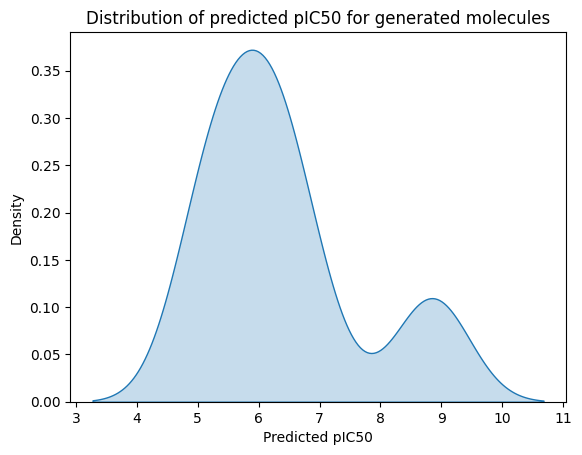

In [17]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator, predictor, n_to_generate=10)


In [18]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=None, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [19]:
# Setting up some parameters for the experiment
n_to_generate = 5
n_policy_replay = 10
n_policy = 5
n_iterations = 1

In [20]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    # Convert previous values to floats
    prev_vals = [v.item() if isinstance(v, torch.Tensor) else v for v in previous_values[-(ma_window_size-1):]]
    new_val = new_value.item() if isinstance(new_value, torch.Tensor) else new_value

    value_ma = np.sum(prev_vals) + new_val
    value_ma = value_ma / (len(prev_vals) + 1)
    return value_ma



In [21]:

def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(prop[0] / 3)


In [22]:
RL_max = Reinforcement(my_generator_max, predictor, get_reward_max)

In [23]:
rewards_max = []

rl_losses_max = []

Policy gradient...:   0%|          | 0/5 [00:00<?, ?it/s]s:\my_works\reactjs\practice\practice2\src\data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
[16:23:40] SMILES Parse Error: syntax error while parsing: COc1cc(-c2cc(nc[n4-c2ccc2OC)ccc2N(C)C)c2ccccc23)c(OC)c(OC)n1
[16:23:40] SMILES Parse Error: check for mistakes around position 18:
[16:23:40] COc1cc(-c2cc(nc[n4-c2ccc2OC)ccc2N(C)C)c2c
[16:23:40] ~~~~~~~~~~~~~~~~~^
[16:23:40] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2cc(nc[n4-c2ccc2OC)ccc2N(C)C)c2ccccc23)c(OC)c(OC)n1' for input: 'COc1cc(-c2cc(nc[n4-c2ccc2OC)ccc2N(C)C)c2ccccc23)c(OC)c(OC)n1'
[16:23:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cccc2c(cccc12)C(=O)NCC1(CCC)OC(Cn2cc(CNC(=O)OCc3cccs3)cc2)CC1)C(=O)Nc1ccc(N)nc1
[16:23:41] SMILES Parse Error: check for mist

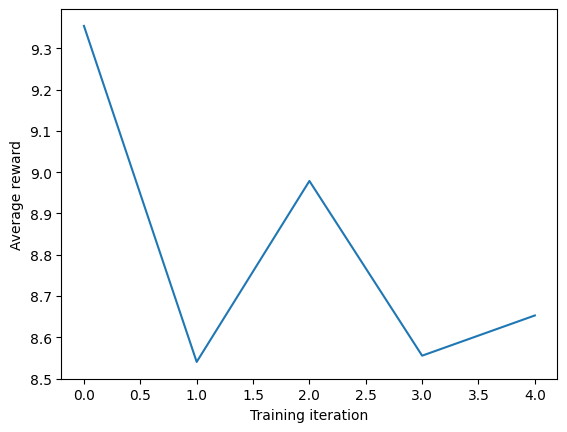

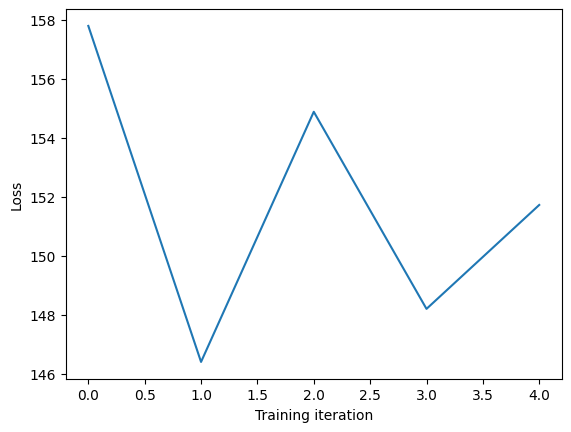

Generating molecules...: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
[16:25:41] SMILES Parse Error: syntax error while parsing: CC(C)CN1C(O)=C(C(OC(=O)c2cccc(c2)C(F)(F)F)c(1)c1ccc(Br)cc1)c1ccc(Cl)cc1
[16:25:41] SMILES Parse Error: check for mistakes around position 45:
[16:25:41] 2cccc(c2)C(F)(F)F)c(1)c1ccc(Br)cc1)c1ccc(
[16:25:41] ~~~~~~~~~~~~~~~~~~~~^
[16:25:41] SMILES Parse Error: Failed parsing SMILES 'CC(C)CN1C(O)=C(C(OC(=O)c2cccc(c2)C(F)(F)F)c(1)c1ccc(Br)cc1)c1ccc(Cl)cc1' for input: 'CC(C)CN1C(O)=C(C(OC(=O)c2cccc(c2)C(F)(F)F)c(1)c1ccc(Br)cc1)c1ccc(Cl)cc1'
[16:25:41] SMILES Parse Error: syntax error while parsing: 4CCCCCCCCCC(O)C(O)C1OC2C(NCC(O)C1O)N(CCc1ccc(Cl)cc1)C2C(O)=O
[16:25:41] SMILES Parse Error: check for mistakes around position 1:
[16:25:41] 4CCCCCCCCCC(O)C(O)C1OC2C(NCC(O)C1O)N(CCc1
[16:25:41] ^
[16:25:41] SMILES Parse Error: Failed parsing SMILES '4CCCCCCCCCC(O)C(O)C1OC2C(NCC(O)C1O)N(CCc1ccc(Cl)cc1)C2C(O)=O' for input: '4CCCCCCCCCC(O)C(O)C1OC2C(NCC(O)C1O)N(CCc1ccc(

Mean value of predictions: 6.6545134
Proportion of valid SMILES: 3.6


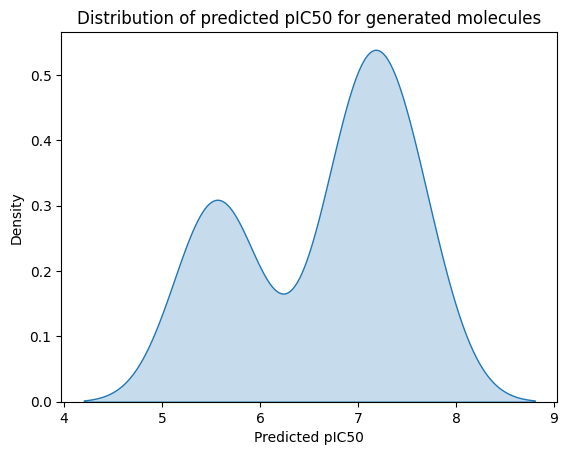

Sample trajectories:
CC(Oc1ccc2c(c1)CCC(=O)N2)c1ccccn1  ---  6.849967002868652
CN(C)C(=O)C1C(C(=O)c2cccc(Cl)c2)=C(N)N1Cc1ccccc1  ---  5.713388919830322
COc1cccc(-c2ccc(Nc3ncnc4[nH]nc(-c5ccc(C(F)(F)F)cc5)c34)c(OC)c2)c1  ---  5.406191349029541
COc1nc(-c2ccc(CN3SC(=O)N(C)C3=O)cc2)ccc1-n1cc2c(c1)C1=CN(CCCCC1)C2=O  ---  7.095808506011963
CS(=O)(=O)N(CCCc1ccccc1C(=O)O)CC(=O)O  ---  7.59981632232666


In [24]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, get_features=get_fp)

        # Apply moving average
        rewards_max.append(simple_moving_average(rewards_max, cur_reward))
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))

    # Plotting (convert to float first)
    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()

    plt.plot(rl_losses_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()

    # Sample molecules and print
    smiles_cur, prediction_cur = estimate_and_update(
        RL_max.generator,
        predictor,
        10,
        get_features=get_fp
    )
    print('Sample trajectories:')
    for i in range(5):
        print(smiles_cur[i]," --- ",prediction_cur[0][i].item())

In [25]:
my_generator.save_model('latest')

In [26]:
my_generator.load_model('latest')